# Liquid biopsy benchmark

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [4]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

prefix = 'dilution_chr22_'
chrom = '22'
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]#, (0.0625, 0.88)]

patient = '1014'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]
    
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None

print(patient, healthysamples)

1014 ['pooledhealthy', 'CRC-1014_090516']


# Caller robustness: GT = calls detected by at least k callers in the undiluted liquid biopsy sample - SNV

pooledhealthy
data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
(275, 16)
(275, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(817, 16)
(275, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(26022, 16)
(123, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(27018, 16)
(135, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_0.5_pooledhealthy_0.81/dilution_chr22_CRC-1014_180816_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(29008, 16)
(131, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(29370, 16)
(118, 16)


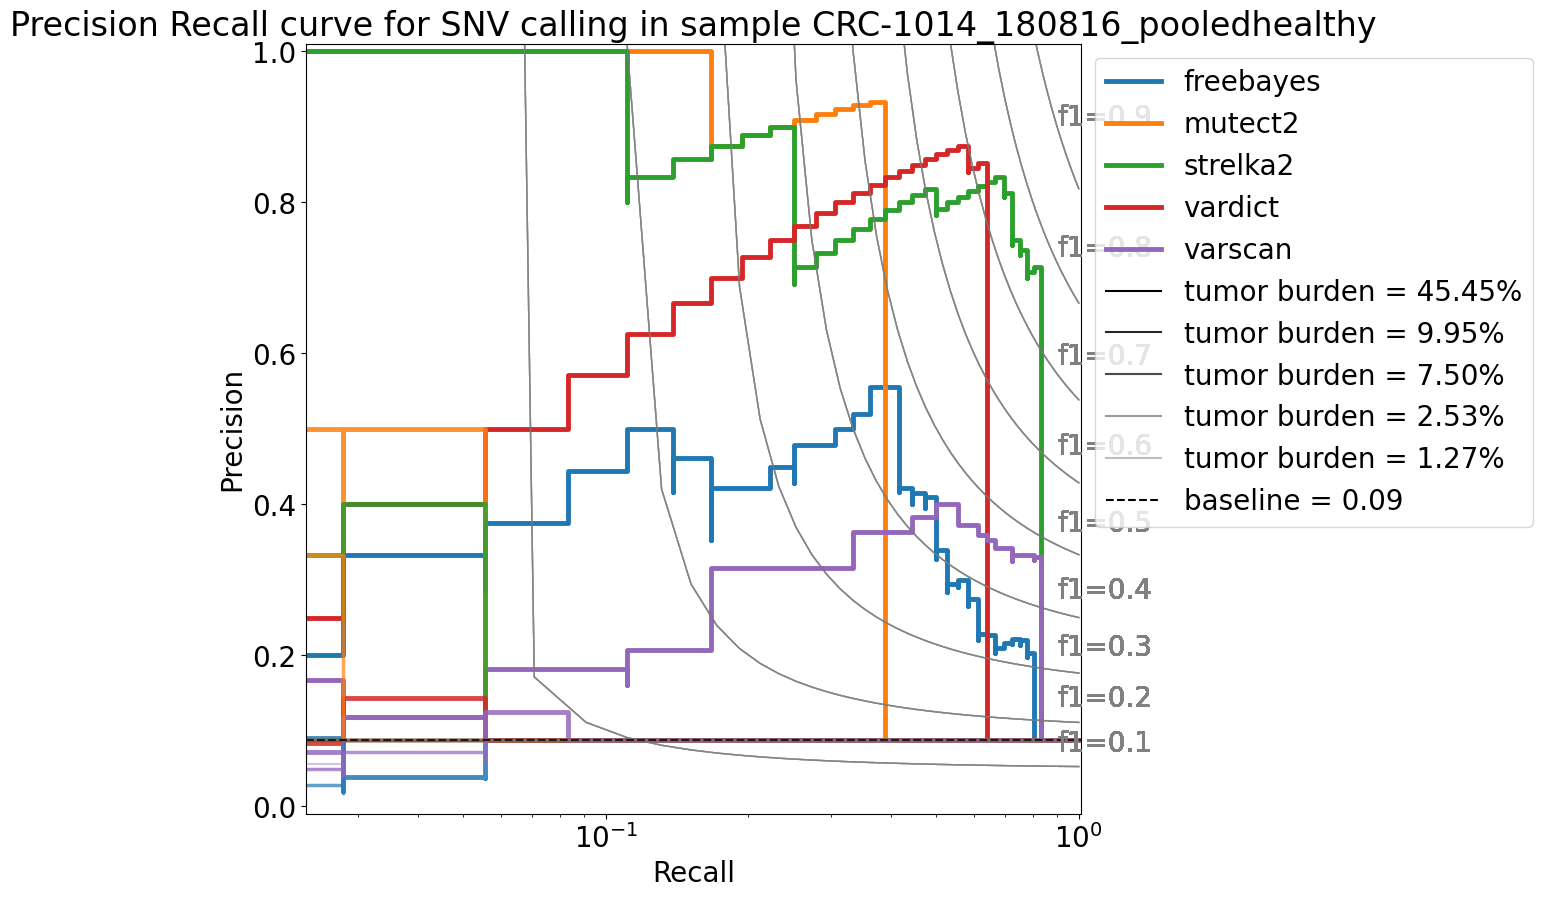

In [5]:
#for healthysample in healthysamples:
#healthysample = healthysamples[-1] 
healthysample = healthysamples[0] 
print(healthysample)
    #try: 
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', vcf_ref_path=vcf_ref_path, tumorsample=None)
figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', save=False)
    #except:
    #    print('pass this call')
    # figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', save=False)
    # for m in config.methods:
    #    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=False)
    #    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=False)

# Caller consistency: GT = calls detected by the same method in the undiluted liquid biopsy sample - SNV

data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
Index(['freebayes_truth', 'mutect2_truth', 'strelka2_truth', 'vardict_truth',
       'varscan_truth'],
      dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
vcf_pd_6 (0.0625, 0.88)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_0.0625_CRC-1014_090516_0.88/dilution_chr22_CRC-1014_180816_0_0625_CRC-1014_090516_0_88-ensemble-annotated.vcf


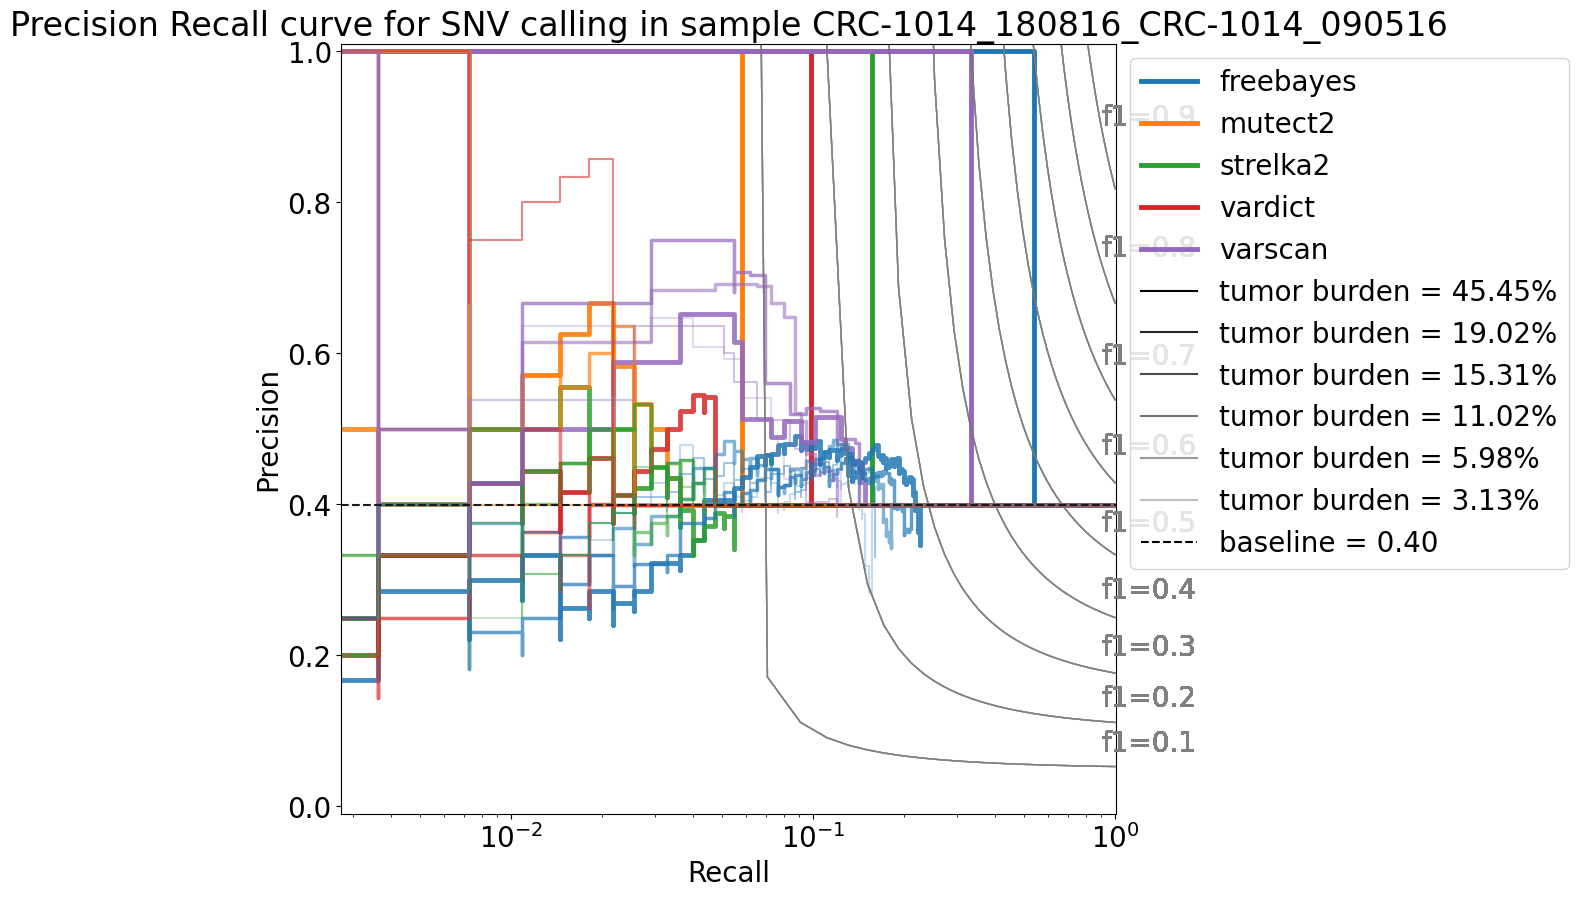

In [45]:
# for healthysample in healthysamples:
healthysample = healthysamples[-1]
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', tumorsample=None, vcf_ref_path=vcf_ref_path)
figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr', ground_truth_method='method', refsample='undiluted', chrom='22', muttype='SNV', save=False)
    #figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr', ground_truth_method='method', refsample='undiluted', chrom='22', muttype='SNV', save=False)
    #for m in config.methods:
    #    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method='method', refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=False)
    #    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method='method', refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=False)

In [42]:
for healthysample in healthysamples:
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', tumorsample=None, vcf_ref_path=vcf_ref_path)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method='method',
                 refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/dilutions_chr22/estimated_tf_chr22_CRC-1014_180816_0.0625_pooledhealthy_0.88.txt'

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*config.bcbiofolder, prefix + plasmasample1 + "_1_pooledhealthy_0", prefix + plasmasample1 + "_1_pooledhealthy_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, config.methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*config.bcbiofolder, prefix+plasmasample1+"_"+str(d[0])+"_"+healthysample+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+healthysample+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, config.methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method+'_score']])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
                
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

# Caller consistency: GT = calls detected by at least 2 methods in the matched tumor sample - SNV

In [47]:
#for healthysample in ['pooledhealthy', 'pooledhealthy_986_filter_snv', 'CRC-986_300316']:
healthysample = healthysamples[-1]
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', tumorsample=tumorsample1)
figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', save=False)
figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr', ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', save=False)

ValueError: no tumor sample passed while gt_sample='tumor'

# ROC curve - SNV - Caller consistency: GT = calls detected by the same method in the undiluted sample

In [ ]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
#vcf_path = os.path.join(*bcbiooutputdirpath, tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
#vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
#vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[config.methods_tissue].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, config.methods_tissue, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape, y_true.shape)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

        for method in config.methods_tissue:
            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            #print(df_sample_method.shape)
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(precision_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['precision'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="precision", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Precision curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(recall_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['recall'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="recall", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Recall curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# F1-score plot

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(f1_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['F1-score'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="F1-score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("F1-score curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# AUPRC plot

In [6]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method+'_score']])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
                
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

NameError: name 'bcbiooutputdirpath' is not defined

In [ ]:

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape, y_true.shape)
            df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

            for method in config.methods:
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

# Figures

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
warnings.filterwarnings('ignore')
# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

prefix = 'dilution_chr22_'
chrom = '22'
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]#, (0.0625, 0.88)]

patient = '986'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]

print(patient, healthysamples)

986 ['pooledhealthy', 'pooledhealthy_986_filter_snv', 'CRC-986_300316']


In [3]:
prefix = '_chr22_CRC_'
dilutionseries = [1, 0.2, 0.15, 0.1, 0.05,0.025]

In [4]:
df_table = get_call_table_spikein(config, prefix, plasmasampleltb, 'data/spikein_chr22/common_mutations_chr22/CRC_MSI/chr22_CRC_MSI_SNV.bed', dilutionseries, msstatus='MSI', chrom='22', muttype='SNV')


               VAF ALT  TRUTH
CHROM_POS                    
22_17416468  0.297   A   True
22_17703486  0.363   A   True
22_18185940  0.300   T   True
22_19129522  0.261   A   True
22_19144793  0.278   T   True
...            ...  ..    ...
22_48350779  0.422   T   True
22_48350791  0.380   T   True
22_49183490  0.282   T   True
22_49296008  0.379   T   True
22_50074717  0.375   T   True

[92 rows x 3 columns]
1
select a single chrom = 22 for analysis
0.2
select a single chrom = 22 for analysis
0.15
select a single chrom = 22 for analysis
0.1
select a single chrom = 22 for analysis
0.05
select a single chrom = 22 for analysis
0.025
select a single chrom = 22 for analysis


In [16]:
df_table.loc['22_50467336']#T.head(50)

VAF                              NaN
ALT                              NaN
TRUTH                          False
vaf_1_freebayes                  NaN
vaf_1_mutect2                    NaN
                              ...   
vaf_0.025_freebayes_score        NaN
vaf_0.025_mutect2_score          NaN
vaf_0.025_strelka2_score         NaN
vaf_0.025_vardict_score      0.89468
vaf_0.025_varscan_score          NaN
Name: 22_50467336, Length: 63, dtype: object

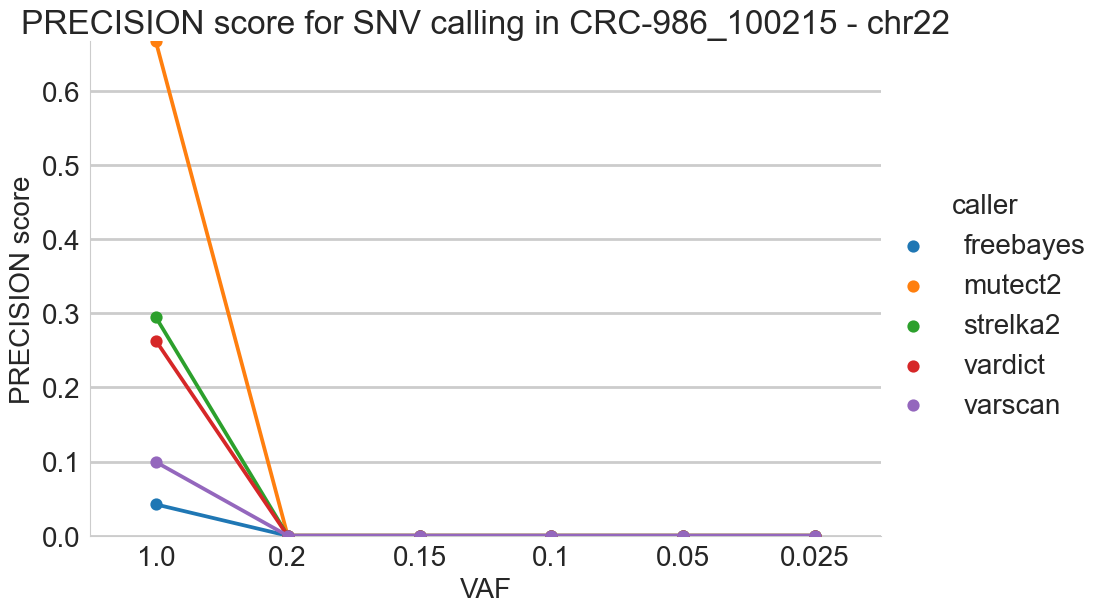

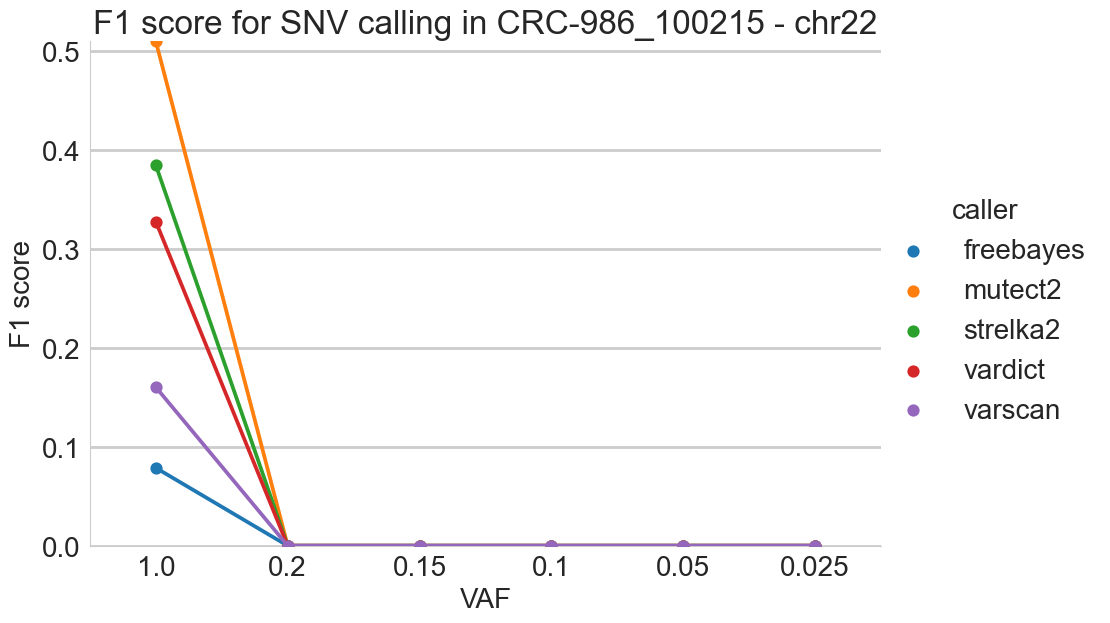

In [18]:
results_auprc_df = metric_curve(config, df_table, plasmasample1, healthysample=None, dilutionseries=dilutionseries, metric='precision', ground_truth_method='spikein', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
results_auprc_df = metric_curve(config, df_table, plasmasample1, healthysample=None, dilutionseries=dilutionseries, metric='f1', ground_truth_method='spikein', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

In [142]:
### CONSENSUS ###
healthysample = plasmasampleltb #  #
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875), (0.0625, 0.88)]
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
results_auprc_df = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
results_f1_df = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
results_precision_df = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

data/bcbio_output/dilution_chr22_CRC-986_100215_1_pooledhealthy_0/dilution_chr22_CRC-986_100215_1_pooledhealthy_0-ensemble-annotated.vcf


KeyboardInterrupt: 

data/bcbio_output/dilution_chr22_CRC-986_100215_1_pooledhealthy_0/dilution_chr22_CRC-986_100215_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1016, 16)
(340, 16)
(340, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(1016, 16)
(340, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(25047, 16)
(153, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(25894, 16)
(149, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(27415, 16)
(146, 16)


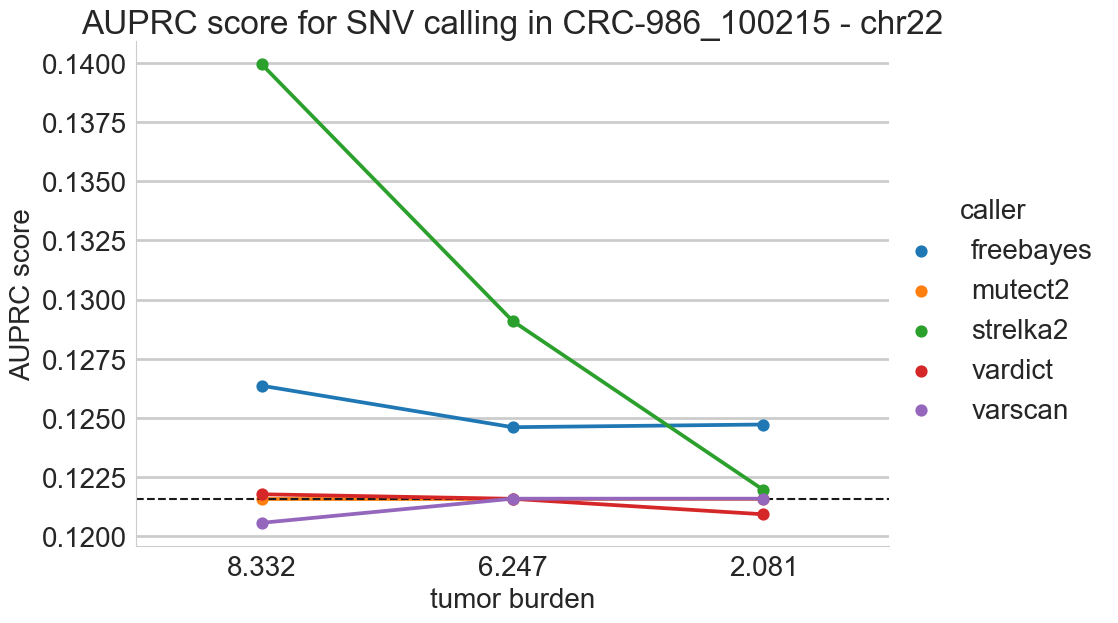

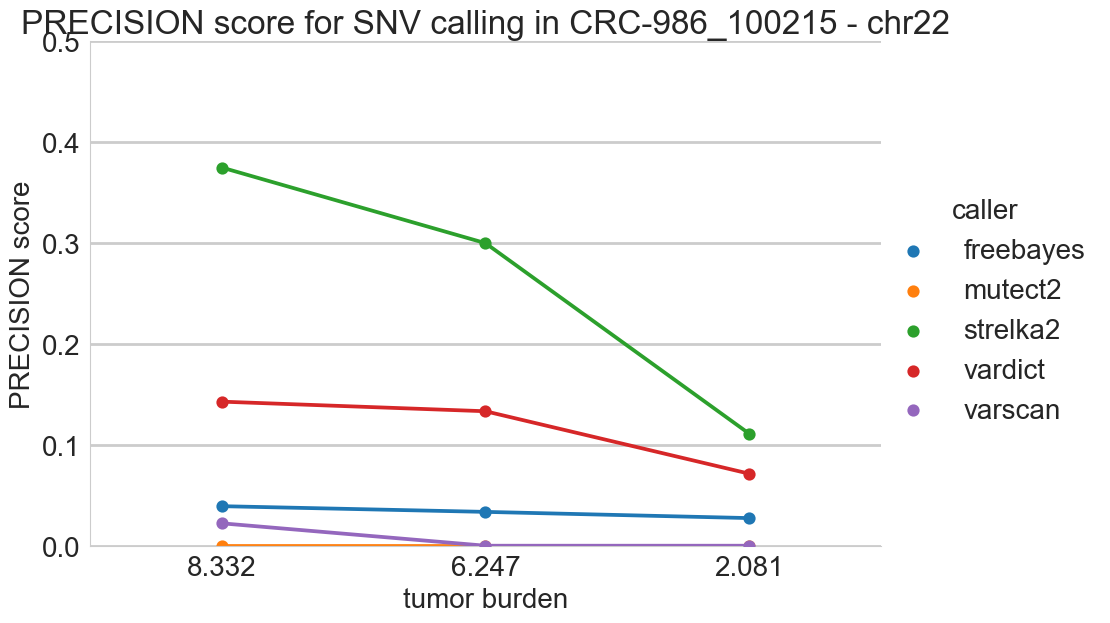

In [188]:
### CONSENSUS Pooled heatlhy ###
healthysample =  'pooledhealthy' 
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855)]#, (0.0625, 0.88)]
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
results_auprc_df_pooledhealthy = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
#results_f1_df = metric_curve(config, df_table, plasmasample1, healthysamplee dilutionseries, metric='f1', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
results_precision_pooledhealthy = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

data/bcbio_output/dilution_chr22_CRC-986_100215_1_pooledhealthy_0/dilution_chr22_CRC-986_100215_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1016, 16)
(340, 16)
(340, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(1016, 16)
(340, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(1495, 16)
(301, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(1443, 16)
(314, 16)
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
(1440, 16)
(311, 16)
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(1591, 16)
(346, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(1509, 16)
(353, 16)


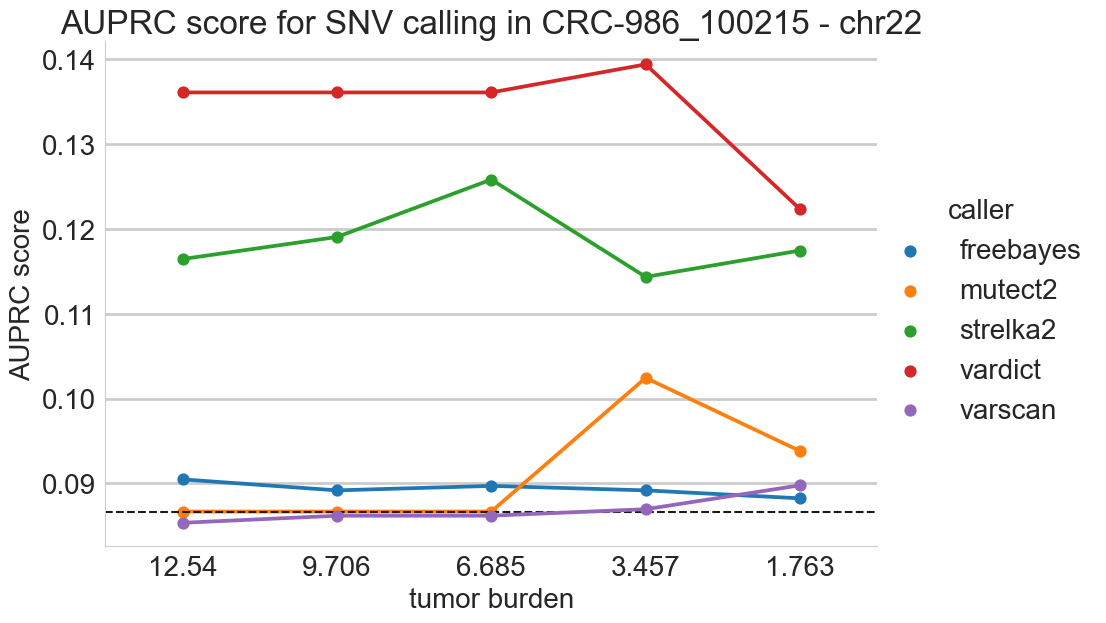

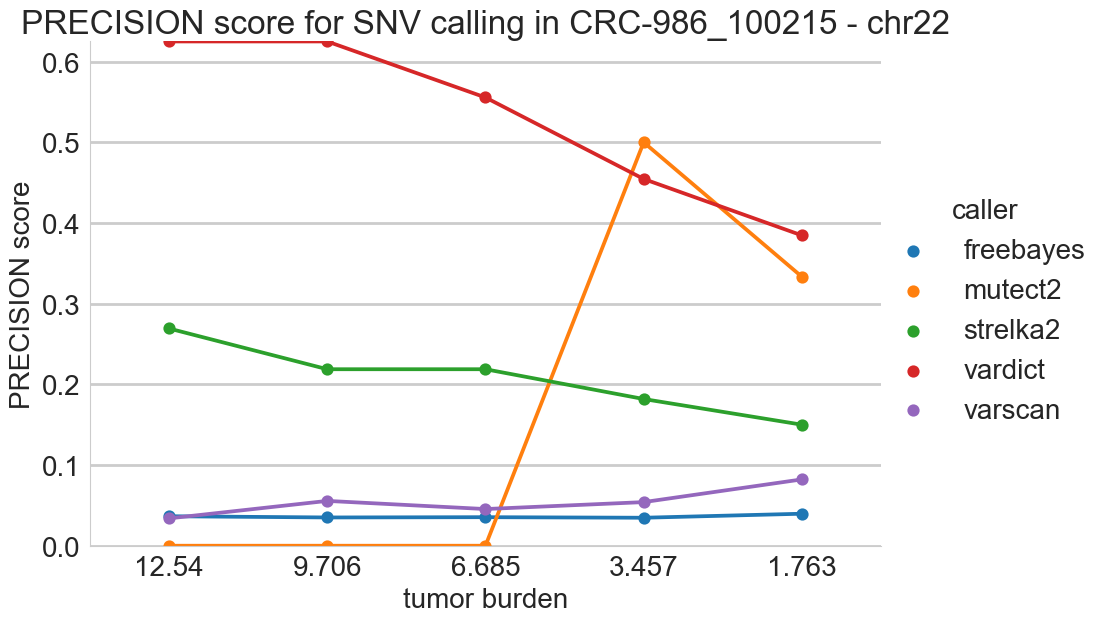

In [189]:
### CONSENSUS Pooled heatlhy ###
healthysample = plasmasampleltb 
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]#, (0.0625, 0.88)]
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
results_auprc_df_lowsampletb = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
#results_f1_df = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
results_precision_lowsampletb = metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

Text(0.5, 1.0, 'PRECISION score for SNV calling in CRC-986_100215 - chr22')

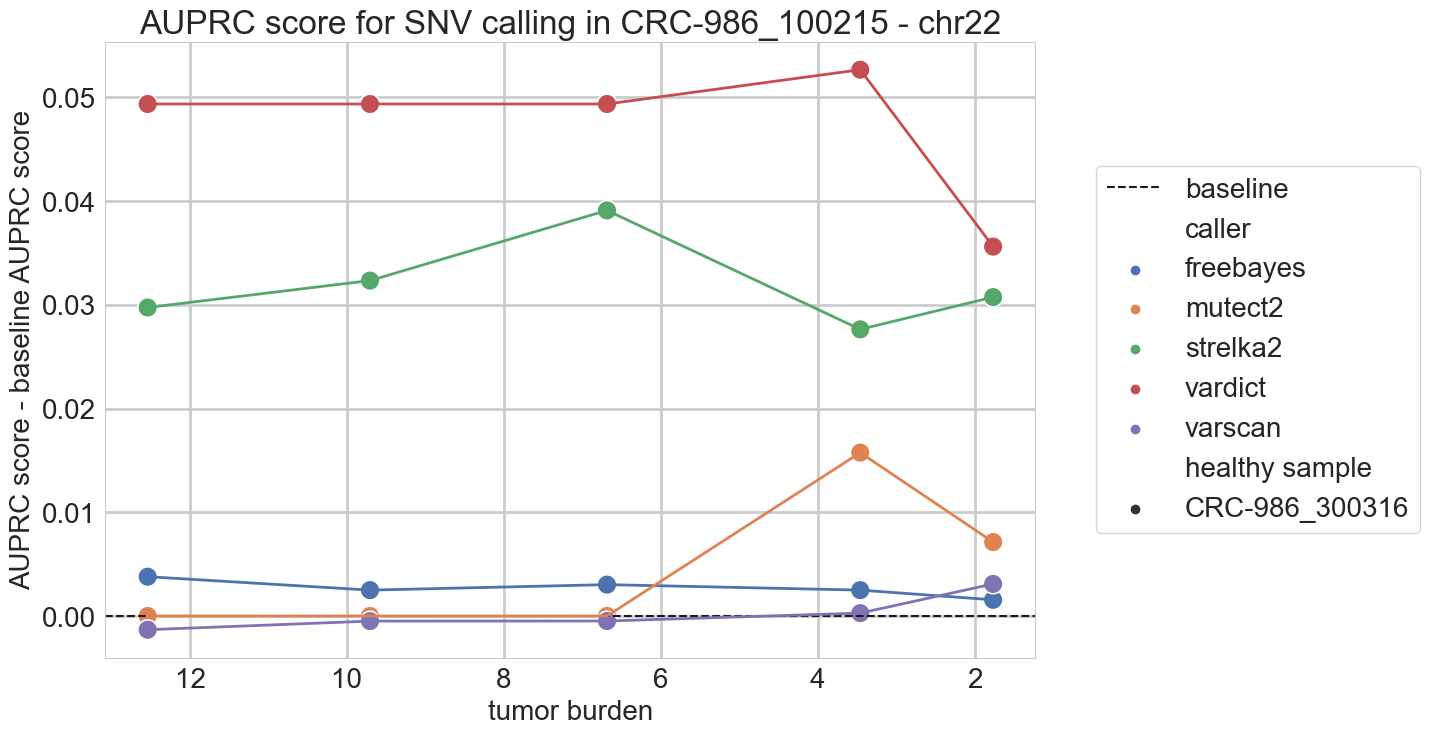

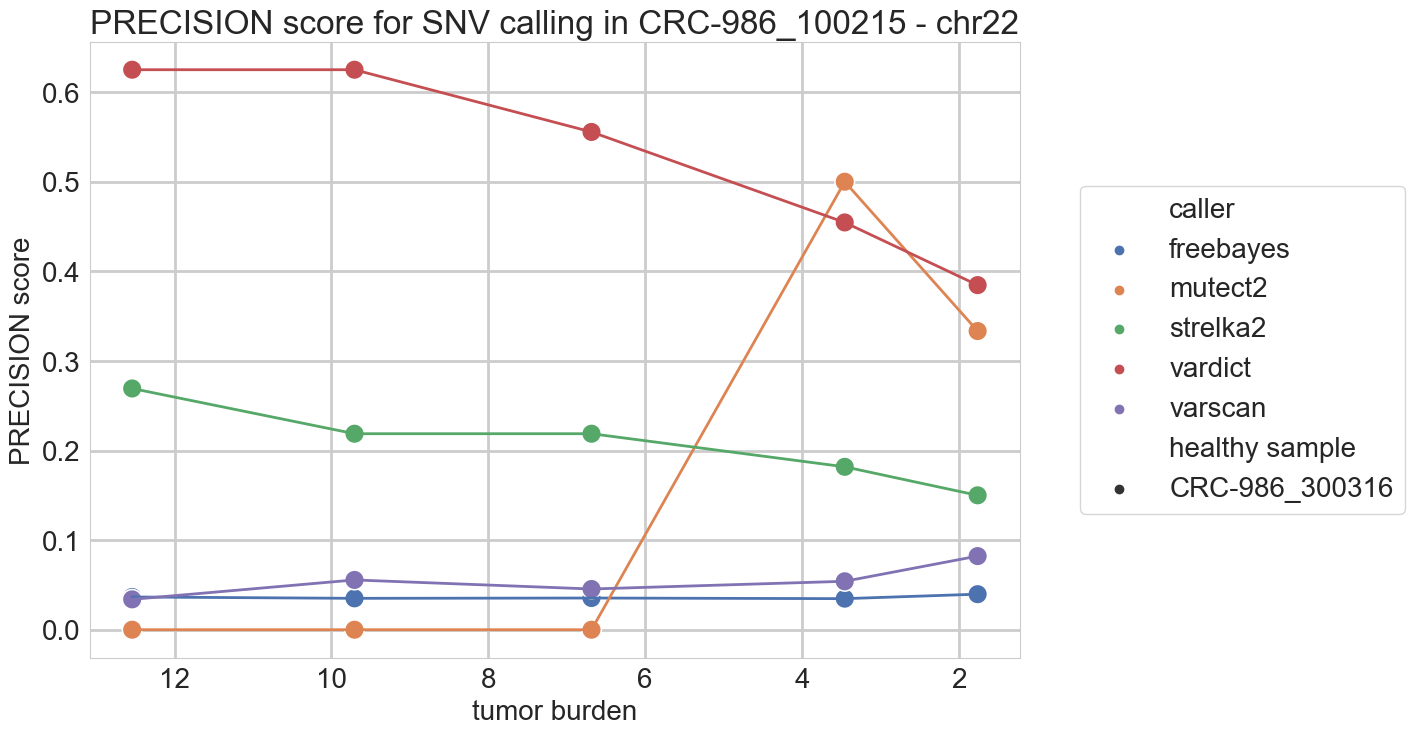

In [190]:
results_auprc = pd.concat([results_auprc_df_lowsampletb])
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(12,8))
plt.axhline(y=0, ls='--', c='k', label='baseline')
g = sns.scatterplot(x="tumor burden", y='AUPRC score - baseline AUPRC score', hue="caller", style='healthy sample', s=200, data=results_auprc)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
g.invert_xaxis()
#sns.lineplot(x = 'tumor burden', y = 'AUPRC score - baseline AUPRC score', ci=None, hue='caller',  lw=2, data = results_auprc_df_pooledhealthy, legend=False)
sns.lineplot(x = 'tumor burden', y = 'AUPRC score - baseline AUPRC score', ci=None, hue='caller',  lw=2, data = results_auprc_df_lowsampletb, legend=False)
plt.title("AUPRC score for {} calling in {} - chr{}".format('SNV', plasmasample1, chrom))

results_precision = pd.concat([results_precision_lowsampletb])
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(12,8))
g = sns.scatterplot(x="tumor burden", y='PRECISION score', hue="caller", style='healthy sample', s=200, data=results_precision)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
g.invert_xaxis()
#sns.lineplot(x = 'tumor burden', y = 'PRECISION score', ci=None, hue='caller', lw=2, data = results_precision_pooledhealthy, legend=False)
sns.lineplot(x = 'tumor burden', y = 'PRECISION score', ci=None, hue='caller', lw=2, data = results_precision_lowsampletb, legend=False)
plt.title("PRECISION score for {} calling in {} - chr{}".format('SNV', plasmasample1, chrom))

Text(0.5, 1.0, 'PRECISION score for SNV calling in CRC-986_100215 - chr22')

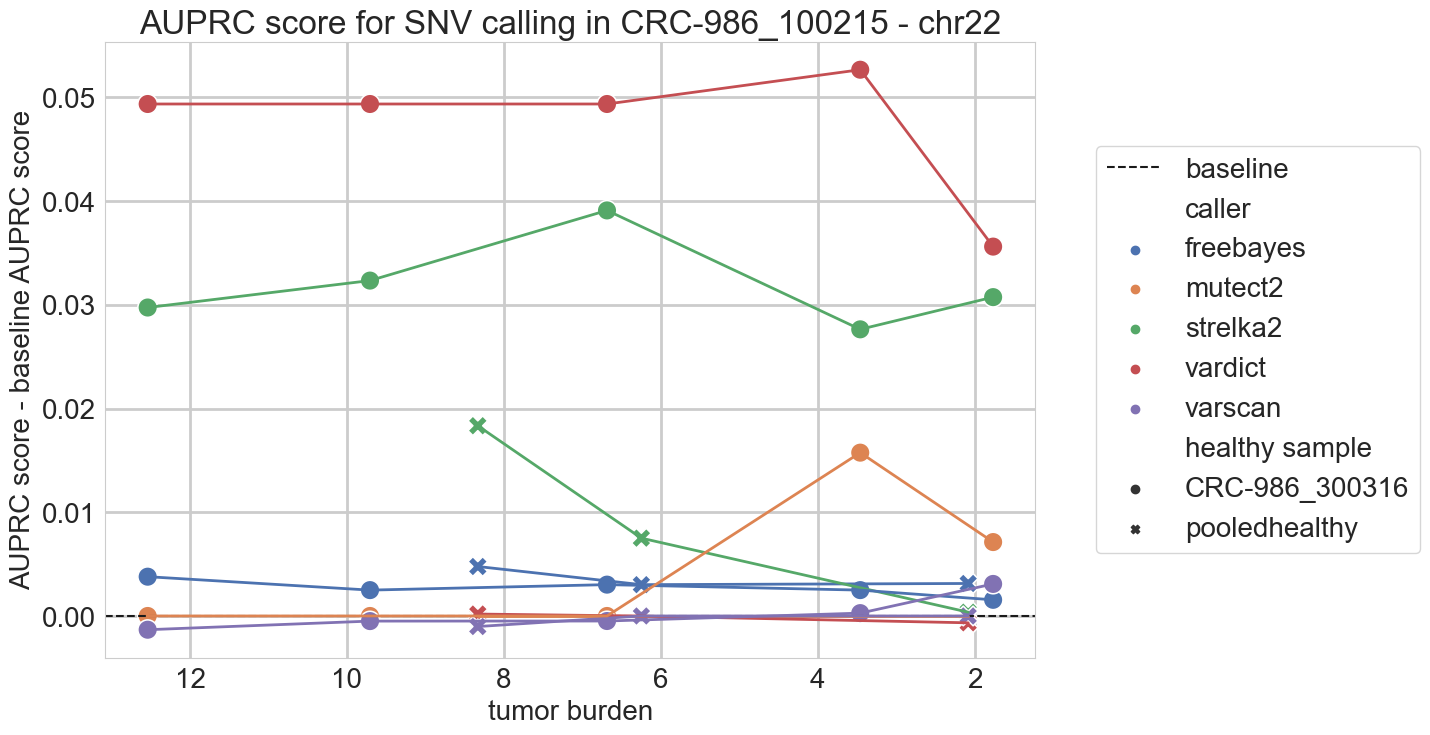

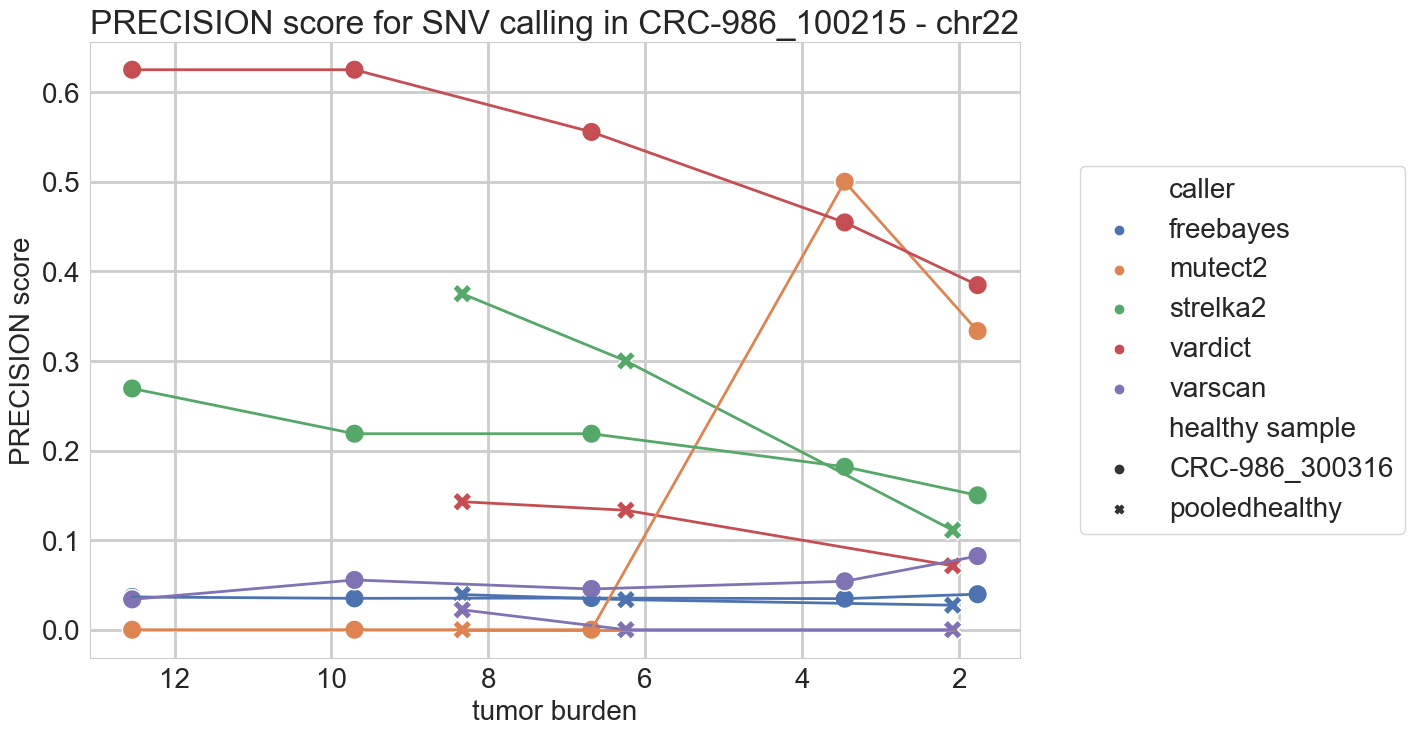

In [191]:
results_auprc = pd.concat([results_auprc_df_lowsampletb, results_auprc_df_pooledhealthy])
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(12,8))
plt.axhline(y=0, ls='--', c='k', label='baseline')
g = sns.scatterplot(x="tumor burden", y='AUPRC score - baseline AUPRC score', hue="caller", style='healthy sample', s=200, data=results_auprc)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
g.invert_xaxis()
sns.lineplot(x = 'tumor burden', y = 'AUPRC score - baseline AUPRC score', ci=None, hue='caller',  lw=2, data = results_auprc_df_pooledhealthy, legend=False)
sns.lineplot(x = 'tumor burden', y = 'AUPRC score - baseline AUPRC score', ci=None, hue='caller',  lw=2, data = results_auprc_df_lowsampletb, legend=False)
plt.title("AUPRC score for {} calling in {} - chr{}".format('SNV', plasmasample1, chrom))

results_precision = pd.concat([results_precision_lowsampletb, results_precision_pooledhealthy])
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(12,8))
g = sns.scatterplot(x="tumor burden", y='PRECISION score', hue="caller", style='healthy sample', s=200, data=results_precision)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
g.invert_xaxis()
sns.lineplot(x = 'tumor burden', y = 'PRECISION score', ci=None, hue='caller', lw=2, data = results_precision_pooledhealthy, legend=False)
sns.lineplot(x = 'tumor burden', y = 'PRECISION score', ci=None, hue='caller', lw=2, data = results_precision_lowsampletb, legend=False)
plt.title("PRECISION score for {} calling in {} - chr{}".format('SNV', plasmasample1, chrom))

data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
Index(['freebayes_truth', 'mutect2_truth', 'strelka2_truth', 'vardict_truth',
       'varscan_truth'],
      dtype='object')
vcf_pd_0 (1, 0)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_1_CRC-1014_090516_0/dilution_chr22_CRC-1014_180816_1_CRC-1014_090516_0-ensemble-annotated.vcf
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis


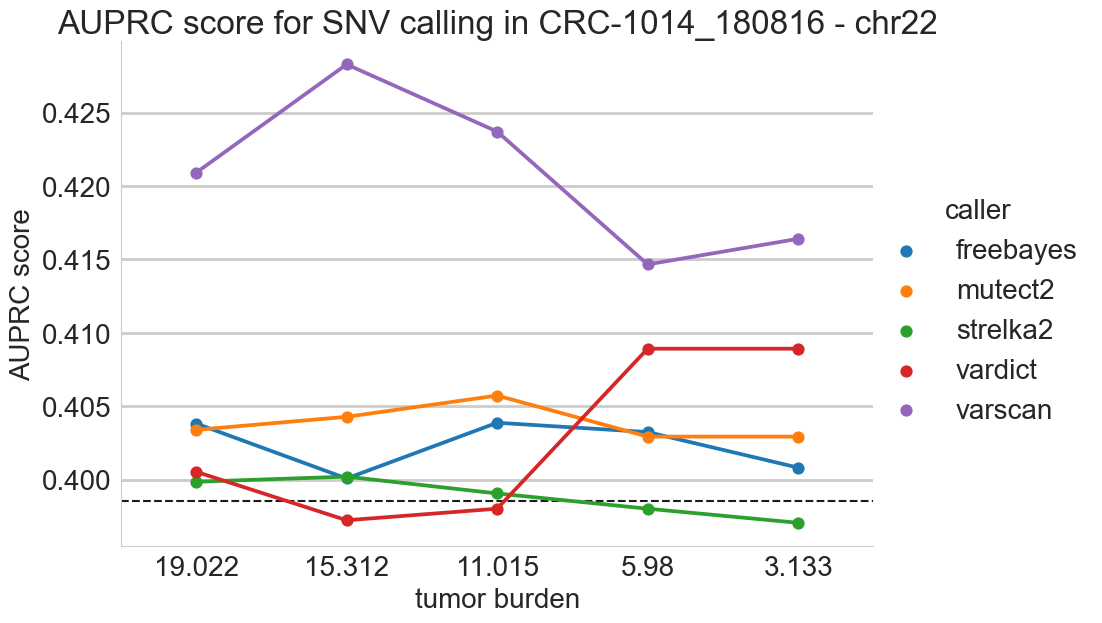

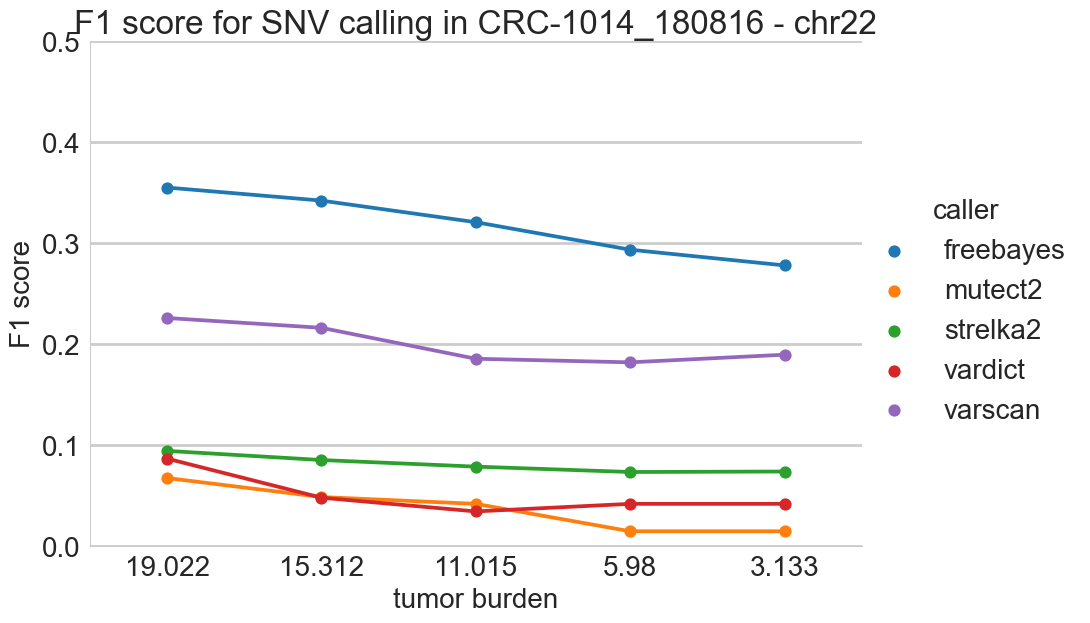

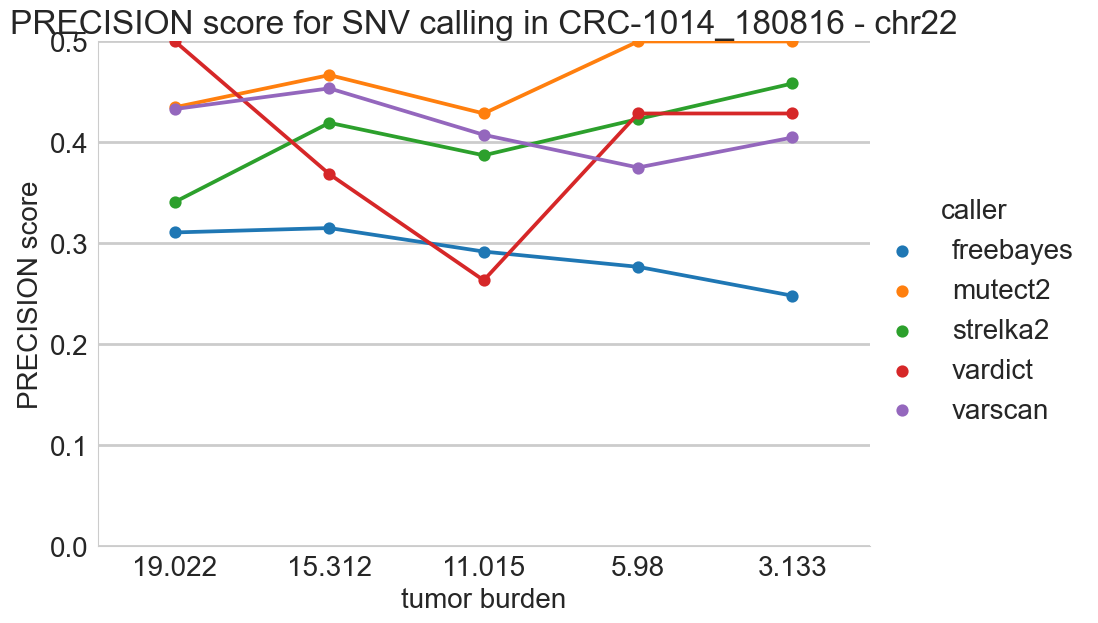

,PRECISION score,tumor burden,caller,plasma sample,healthy sample,mutation type,metric
0,0.310627,19.022,freebayes,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
1,0.434783,19.022,mutect2,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
2,0.340909,19.022,strelka2,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
3,0.500000,19.022,vardict,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
4,0.432990,19.022,varscan,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
5,0.314985,15.312,freebayes,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
6,0.466667,15.312,mutect2,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
7,0.419355,15.312,strelka2,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
8,0.368421,15.312,vardict,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision
9,0.453488,15.312,varscan,CRC-1014_180816,CRC-1014_090516,inundilutedsamplebythesamecaller,precision


In [9]:
### CONSISTENCY ###
healthysample = plasmasampleltb #'pooledhealthy'
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=False)

# True Positive, False Negative and False Positive Mutations

In [22]:
vcf_sample

,truth,19.022_freebayes,19.022_mutect2,19.022_strelka2,19.022_vardict,19.022_varscan,19.022_freebayes_score,19.022_mutect2_score,19.022_strelka2_score,19.022_vardict_score,...,3.133_freebayes,3.133_mutect2,3.133_strelka2,3.133_vardict,3.133_varscan,3.133_freebayes_score,3.133_mutect2_score,3.133_strelka2_score,3.133_vardict_score,3.133_varscan_score
22_16228500,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228507,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228527,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228528,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228531,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_44632418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,NaN,NaN,NaN,NaN,0.719227,NaN,NaN,NaN,NaN
22_44632427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,NaN,NaN,NaN,NaN,0.719227,NaN,NaN,NaN,NaN
22_47002046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_47317503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,NaN,NaN,NaN,True,0.850641,NaN,NaN,NaN,8.0


In [28]:
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity', 'metric', 'number of loci']) #'TN', 'FP', 'FN', 'TP'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0

for muttype in config.muttype:
    for method in config.methods:
        print(muttype, sample, method)
        for d in dilutionseries:
            if d != (1,0):
                tb = float(pd.read_csv(os.path.join(*config.dilutionfolder, "estimated_tf_chr22_" + plasmasample1 +"_" + str(d[0]) +"_" + healthysample + "_" + str(d[1]) + ".txt")).columns[0])
                vcf_sample = df_table
                tn, fp, fn, tp = confusion_matrix(vcf_sample['truth'], vcf_sample[str(round(100*tb, 3))+'_'+method], labels=[0,1]).ravel()
                for tfpn in [tn, fp, fn, tp]:
                    # df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), tn, fp, fn, tp]
                    df.loc[c, :] = [sample, muttype, method, str(round(100*tb,3)), metric[c%4], tfpn]
                    c += 1
df.head()

data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
(275, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_1_CRC-1014_090516_0/dilution_chr22_CRC-1014_180816_1_CRC-1014_090516_0-ensemble-annotated.vcf
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
snv icgc_cll_tumour freebayes


ValueError: unknown is not supported

In [ ]:
for muttype in config.muttype:
    sns.catplot(x="caller", y="number of loci", hue="purity", col="sample", data=df[(df['mutation type'] == muttype) & (df['metric'] == 'TP')], kind="bar", ci=None, palette="Blues_d", 
               height=10, aspect=1.5)
    plt.suptitle('True Positive calls - '+muttype)
    #plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_TP',  bbox_inches='tight')

    sns.catplot(x="caller", y="number of loci", hue="purity", col="sample", data=df[(df['mutation type'] == muttype) & (df['metric'] == 'FP')], kind="bar", ci=None, palette="Blues_d", 
               height=10, aspect=1.5)
    plt.suptitle('False Positive calls - '+muttype)
    #plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_FP',  bbox_inches='tight')

    sns.catplot(x="caller", y="number of loci", hue="purity", col="sample", data=df[(df['mutation type'] == muttype) & (df['metric'] == 'FN')], kind="bar", ci=None, palette="Blues_d", 
               height=10, aspect=1.5)
    plt.suptitle('False Negative calls - '+muttype)
    #plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_FN',  bbox_inches='tight')


In [16]:
## TUMOR ###
healthysample = plasmasampleltb #'pooledhealthy' 
if patient != '1014':
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', tumorsample=tumorsample1, vcf_ref_path=None)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=False)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=False)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=False)

data/bcbio_output/NCC_CRC-986_100215-T1W/NCC_CRC-986_100215-T1W-ensemble-annotated.vcf
sample is not present with path data/bcbio_output/NCC_CRC-986_100215-T1W/NCC_CRC-986_100215-T1W-ensemble-annotated.vcf


AttributeError: 'NoneType' object has no attribute 'shape'

# True Positives, False Negatives, False positives

In [137]:
# ISSUE WITH INDEL 
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=1, refsample='undiluted', chrom='22', muttype='INDEL', vcf_ref_path=vcf_ref_path)
df_table

data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
(0, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
vcf_pd_6 (0.0625, 0.88)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_0.0625_CRC-1014_090516_0.88/dilution_chr22_CRC-1014_180816_0_0625_CRC-1014_090516_0_88-ensemble-annotated.vcf


,truth,45.45_freebayes,45.45_mutect2,45.45_strelka2,45.45_vardict,45.45_varscan,45.45_freebayes_score,45.45_mutect2_score,45.45_strelka2_score,45.45_vardict_score,...,3.133_freebayes,3.133_mutect2,3.133_strelka2,3.133_vardict,3.133_varscan,3.133_freebayes_score,3.133_mutect2_score,3.133_strelka2_score,3.133_vardict_score,3.133_varscan_score
CHROM_POS,,,,,,,,,,,,,,,,,,,,,


In [129]:
df = pd.DataFrame(columns=['mutation type', 'caller', 'tumor burden', 'metric', 'number of loci', 'rate',  'number of mutations (ground truth)'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
for muttype in config.muttype:
        print(muttype)
        df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom='22', muttype=muttype.upper(), vcf_ref_path=vcf_ref_path)
        ntruth = sum(df_table['truth'].fillna(False))
        print(ntruth)
        for d in dilutionseries:
            tb = round(100*float(pd.read_csv(os.path.join(*config.dilutionfolder, "estimated_tf_chr22_" + plasmasample1 +"_" + str(d[0]) +"_" + healthysample + "_" + str(d[1]) + ".txt")).columns[0]), 3)
            if d != (1,0):
                for method in config.methods:
                    if str(tb)+'_'+method in df_table.columns:
                        tn, fp, fn, tp = confusion_matrix(df_table['truth'].fillna(False), df_table[str(tb)+'_'+method].fillna(False), labels=[0,1]).ravel()
                        ntruth = sum(df_table['truth'].fillna(False))
                        tpfn = tp + fn
                        tnfp = tn + fp
                        for j, tfpn in enumerate([tn, fp, fn, tp]):
                            if j in [0, 1]:
                                df.loc[c, :] = [muttype, method, tb, metric[c%4], tfpn, tfpn/tnfp, ntruth]
                            else: # j in [2,3]
                                df.loc[c, :] = [muttype, method, tb, metric[c%4], tfpn, tfpn/tpfn, ntruth]
                            c += 1
df.head(20)

snv
data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
(275, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
vcf_pd_6 (0.0625, 0.88)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_180816_0.0625_CRC-1014_090516_0.88/dilution_chr22_CRC-1014_180816_0_0625_CRC-1014_090516_0_88-ensemble-annotated.vcf
36
indel
data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analy

,mutation type,caller,tumor burden,metric,number of loci,rate,number of mutations (ground truth)
0,snv,freebayes,19.022,TN,304,0.464832,36
1,snv,freebayes,19.022,FP,350,0.535168,36
2,snv,freebayes,19.022,FN,19,0.527778,36
3,snv,freebayes,19.022,TP,17,0.472222,36
4,snv,mutect2,19.022,TN,641,0.980122,36
5,snv,mutect2,19.022,FP,13,0.0198777,36
6,snv,mutect2,19.022,FN,26,0.722222,36
7,snv,mutect2,19.022,TP,10,0.277778,36
8,snv,strelka2,19.022,TN,620,0.948012,36
9,snv,strelka2,19.022,FP,34,0.0519878,36


In [130]:
df

,mutation type,caller,tumor burden,metric,number of loci,rate,number of mutations (ground truth)
0,snv,freebayes,19.022,TN,304,0.464832,36
1,snv,freebayes,19.022,FP,350,0.535168,36
2,snv,freebayes,19.022,FN,19,0.527778,36
3,snv,freebayes,19.022,TP,17,0.472222,36
4,snv,mutect2,19.022,TN,641,0.980122,36
...,...,...,...,...,...,...,...
195,indel,vardict,3.133,TP,0,NaN,0
196,indel,varscan,3.133,TN,0,NaN,0
197,indel,varscan,3.133,FP,0,NaN,0
198,indel,varscan,3.133,FN,0,NaN,0


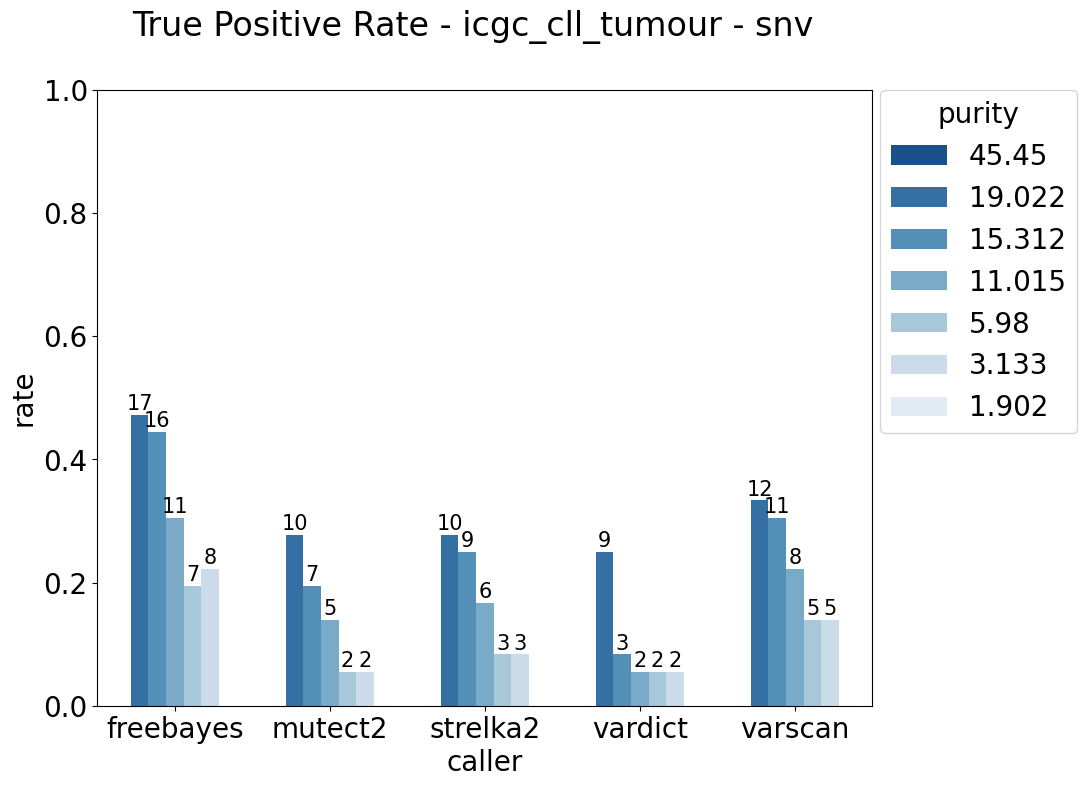

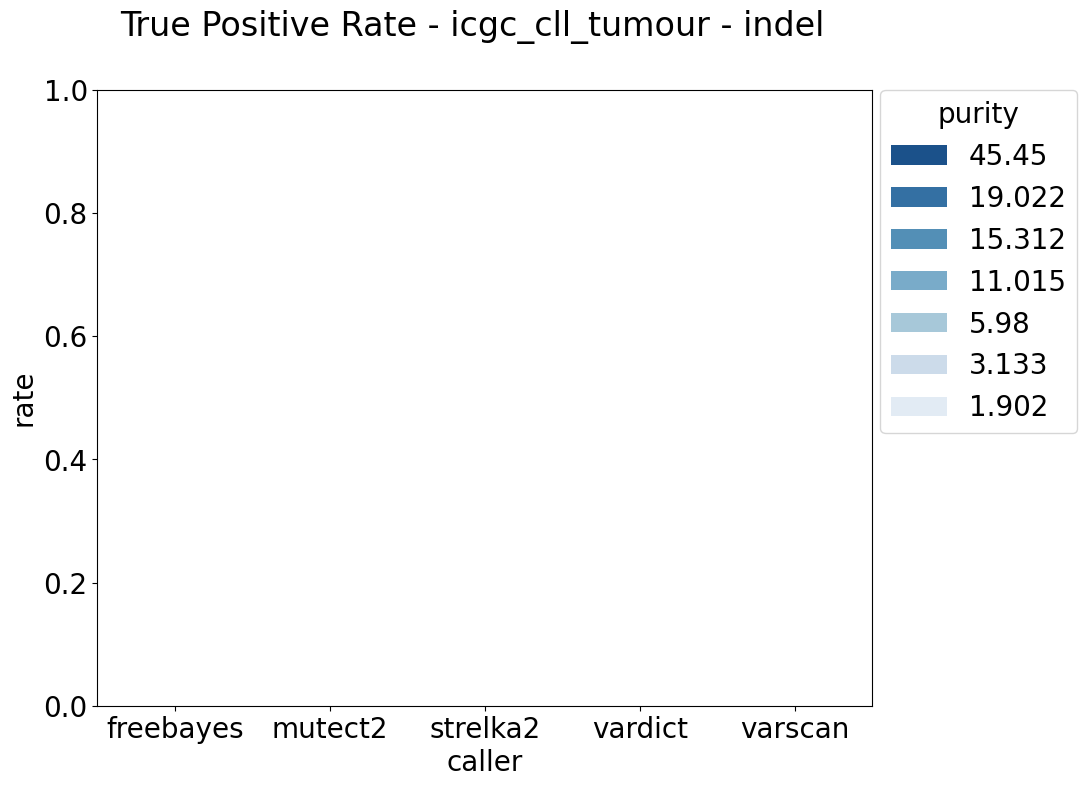

In [123]:
for muttype in config.muttype:
    tblist = [round(100*float(pd.read_csv(os.path.join(*config.dilutionfolder, "estimated_tf_chr22_" + plasmasample1 +"_" + str(d[0]) +"_" + healthysample + "_" + str(d[1]) + ".txt")).columns[0]), 3) for d in dilutionseries]
    plt.figure(figsize=(10,8))
    plots = sns.barplot(x="caller", y="rate", hue="tumor burden", data=df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'TP')], ci=None, palette='Blues_r', hue_order = tblist)
    plt.suptitle('True Positive Rate - '+sample+ ' - '+muttype)
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title='purity')
    plt.ylim([0,1])
    xcoords, ycoords = [], []
    ci = 0
    # Iterrating over the bars one-by-one
    for b, bar in enumerate(plots.patches):
        if not df[(df['mutation type'] == muttype) & (df['metric'] == 'TP') & (df['caller'] == config.methods[b%5]) & (df['tumor burden'] == tblist[b//5 ])]['number of loci'].empty:
            plots.annotate(df[(df['mutation type'] == muttype) & (df['metric'] == 'TP') & (df['caller'] == config.methods[b%5]) & (df['tumor burden'] == tblist[b//5 ])]['number of loci'].values[0],
                           (bar.get_x() + (bar.get_width() / 2), bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8), textcoords='offset points')

    #for m,methods in enumerate(config.methods):
    #    for b, bar in enumerate(plots.patches):
    #        if b % len(config.methods) == m:
    #            #print(b)
    #            if len(xcoords) == 3:
    #                xcoords, ycoords = [], []
    #            xi = bar.get_x() + (bar.get_width() / 2)
    #            yi = df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['caller'] == config.methods[b//3]) & (df['tumor burden'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b%3], 2))]['number of mutations (ground truth)'].values[0]
    #            xcoords.append(xi)
    #            ycoords.append(yi)
    #            if len(xcoords) == 3:
    #                if m == 0:
    #                    redline = ax.plot(xcoords, ycoords, 'ro-', label='Number of ground truths mutations')
    #                else:
    #                    ax.plot(xcoords, ycoords, 'ro-')

False